<a href="https://colab.research.google.com/github/davemcg/scEiaD/blob/master/colab/Query_scEiaD_with_scANVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Querying scEiaD with scVI

## tldr 

You can take your (retina) scRNA and overlay it onto [our](https://plae.nei.nih.gov) scEiaD (single cell Eye in a Disk) with minimuim fuss. This allows you to:

## more reading
1. Quickly check whether your sequencing worked (if most of your cells lay outside the known retina cell types...then likely something went wrong)
2. Quickly see whether the cell types of the retina that you expect are present   
  - a pan-retina scRNA will have very different proportions of the retinal cell types than a flow-sorted (for some marker) experiment
3. Label your cell types by looking for overlaps between scEiaD and your data
  - In the future we will also share our xgboost model so you can auto-label your data with our highly trained xgboost-based machine learning model. 
4. Is your organoid / cell line semi-comparable to primary tissue?

## What does scVI do?
Very briefly, the raw cell x gene expression counts (labelled only with the study/batch covariate) are given to scVI, which uses a [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) to model the counts. The model can output batch corrected "latent dimensions" which are the equivalent of running a PCA on the counts.

The scVI latent dimensions can be fed into the scanpy/Seurat/etc clustering/UMAP tools. 

A recent (version >= 0.8.0) update to scVI uses the "scArches" approach to encode the batches in a way that allows the model to be re-used with *new* data (that the scVI model has never seen). 

The Yosef Lab folks use the "reference" and "query" terms. In this case, reference is the scVI model built for scEiaD. Query is outside data. If you query (or project) your data with the scVI/scEiaD model, then you will get a set of latent dimensions that you use to make a UMAP visualization that will  approximate the one hosted at https://plae.nei.nih.gov. It won't be identical because the UMAP is run again with new data...in the future we will look into whether some of the new UMAP tools to update projections based on new data can be used. 


## Overview
1. Install scvi and kallisto-bustools
2. Download:
  - our kallisto index
  - our scVI model
  - mini versions of the scEiaD
4. Quantify SRA sample `SRR10887776` with kallisto-bustools (this is a retinal organoid...so this could get funky)
5. Preprocess the h5ad object and glue scEiaD with SRR10887776
6. Querying SRA dataset `SRR10887776` (merged with the scEiaD data) with scVI
7. Visualize result
8. Export result for Seurat usage




# Install scvi and kallisto-bustools

In [1]:
import sys
import re
#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]==0.15.0
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

!pip install --quiet kb-python


     |████████████████████████████████| 257 kB 12.8 MB/s 
     |████████████████████████████████| 197 kB 31.2 MB/s 
     |████████████████████████████████| 96 kB 3.2 MB/s 
     |████████████████████████████████| 527 kB 56.3 MB/s 
     |████████████████████████████████| 283 kB 69.2 MB/s 
     |████████████████████████████████| 718 kB 67.2 MB/s 
     |████████████████████████████████| 419 kB 101.8 MB/s 
     |████████████████████████████████| 140 kB 57.2 MB/s 
     |████████████████████████████████| 232 kB 65.6 MB/s 
     |████████████████████████████████| 4.8 MB 36.1 MB/s 
     |████████████████████████████████| 2.0 MB 39.0 MB/s 
     |████████████████████████████████| 135 kB 55.2 MB/s 
     |████████████████████████████████| 1.3 MB 41.8 MB/s 
     |████████████████████████████████| 8.8 MB 25.7 MB/s 
     |████████████████████████████████| 1.1 MB 52.4 MB/s 
     |████████████████████████████████| 596 kB 51.2 MB/s 
     |████████████████████████████████| 952 kB 58.6 MB/s 
     |█████████

# Download our kallisto index
As our example set is human, we use the human Gencode v35 transcript reference.

Nothing funky was done to make it, but the index creation requires around 32GB of memory, so it cannot be done in colab. Plus it takes 30 minutes or so. 

The index was created with this command:

`kallisto index gencode.v35.transcripts.fa.gz -i gencode.v35.transcripts.idx`

The transcript 2 gene file was made with this command:

`zgrep "^>" gencode.v35.transcripts.fa.gz | sed 's/>//g' | awk 'BEGIN {OFS = "\t"; FS = "|"}; {print $0, $2, $2}' | > v35.tr2g.tsv`

and (to remove the .\d ending from the ENSG)

`cat v35.tr2g.tsv |  awk -F'\t' -vOFS='\t' '{ gsub("\\.[0-9]*", "", $2) ; print }' | awk -F'\t' -vOFS='\t' '{ gsub("\\.[0-9]*", "", $3) ; print }' > v35.tr2gX.tsv` 


(Download links):
```
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.v35.transcripts.idx
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/v35.tr2gX.tsv

https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.vM25.transcripts.idx
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/vM25.tr2gX.tsv
```


In [2]:
%%time
!wget -O idx.idx https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.v35.transcripts.idx
!wget -O t2g.txt https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/v35.tr2gx.tsv

--2022-06-13 18:07:00--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.v35.transcripts.idx
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3204112341 (3.0G) [application/octet-stream]
Saving to: ‘idx.idx’

idx.idx             100%[===================>]   2.98G  13.5MB/s    in 4m 16s  

2022-06-13 18:11:16 (11.9 MB/s) - ‘idx.idx’ saved [3204112341/3204112341]

--2022-06-13 18:11:16--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/v35.tr2gx.tsv
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34042406 (32M) [application/octet-stream]
Saving to: ‘t2g.txt’

t2g.txt             100%[===================>]  32.46M  18.5MB/s    in 1.8s    

2022-06-13 18:11:18 (18.5 MB/s) - ‘t

# Quantify with kbtools (Kallisto - Bustools wrapper) in one easy step.

Going into the vagaries of turning a SRA deposit into a non-borked pair of fastq files is beyond the scope of this document. Plus I would swear a lot. So we just give an example set from a Human organoid retina 10x (version 2) experiment.

The Pachter Lab has a discussion of how/where to get public data here: https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/data_download.ipynb

If you have your own 10X bam file, then 10X provides a very nice and simple tool to turn it into fastq file here: https://github.com/10XGenomics/bamtofastq

To reduce run-time we have taken the first five million reads from this fastq pair.

This will take ~3 minutes, depending on the internet speed between Google and our server

You can also directly stream the file to improve wall-time, but I was getting periodic errors, so we are doing the simpler thing and downloading each fastq file here first.

 

In [3]:
%%time
!wget -O sample_1.fastq.gz https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR10887776_1.head.fastq.gz
!wget -O sample_2.fastq.gz https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR10887776_2.head.fastq.gz
!kb count --overwrite --h5ad -i idx.idx -g t2g.txt -x DropSeq -o output --filter bustools -t 2 \
  sample_1.fastq.gz \
  sample_2.fastq.gz

--2022-06-13 18:11:19--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR10887776_1.head.fastq.gz
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149675347 (143M) [application/octet-stream]
Saving to: ‘sample_1.fastq.gz’

sample_1.fastq.gz   100%[===================>] 142.74M  33.1MB/s    in 5.1s    

2022-06-13 18:11:24 (28.1 MB/s) - ‘sample_1.fastq.gz’ saved [149675347/149675347]

--2022-06-13 18:11:24--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR10887776_2.head.fastq.gz
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374309257 (357M) [application/octet-stream]
Saving to: ‘sample_2.fastq.gz’

sample_2.fastq.gz   100%[===================>] 356.97M  14.1MB/s    in 30s


# Download our scEiaD anndata objects and scVI model

scVI was first run on a human-only subset of the data to create a sensical arrangement of cell types (things can get weird when scVI has to handle celltypes, different studies, different technologies, AND different species). The mouse and macaque data were then projected onto it. So thus we will provide two (mini*) anndata objects: the human reference data ("ref") and the mouse/macaque data ("query").

We will later glue the totally new data (SRR12130660) onto the query anndata object.

\* 12GB max memory usage here!

In [ ]:
%%time
import scvi
import scanpy as sc
import pandas as pd 
#sc.set_figure_params(figsize=(8, 8))

!wget -O scEiaD_ref.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/2022_02_22/scEiaD_all_anndata_mini_ref.h5ad
!wget -O scEiaD_query.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/2022_02_22/scEiaD_all_anndata_mini_query.h5ad
adata_scEiaD_ref = sc.read_h5ad('scEiaD_ref.h5ad')
adata_scEiaD_query = sc.read_h5ad('scEiaD_query.h5ad')

# Download the scEiaD scVI model and untar
!wget -O scVI_scEiaD.tgz https://hpc.nih.gov/~mcgaugheyd/scEiaD/2021_03_17/2021_03_17__scVI_scEiaD.tgz
!tar -xzf scVI_scEiaD.tgz
# Set scVI model path
scVI_model_dir_path = 'scVIprojectionSO_scEiaD_model/n_features-5000__transform-counts__partition-universe__covariate-batch__method-scVIprojectionSO__dims-8'
# Read in HVG genes used in scVI model
var_names = pd.read_csv(scVI_model_dir_path + '/var_names.csv', header = None)

--2021-04-13 18:51:09--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/2021_03_17/scEiaD_all_anndata_mini_ref.h5ad
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145947374 (139M) [application/octet-stream]
Saving to: ‘scEiaD_ref.h5ad’

scEiaD_ref.h5ad     100%[===================>] 139.19M   111MB/s    in 1.3s    

2021-04-13 18:51:11 (111 MB/s) - ‘scEiaD_ref.h5ad’ saved [145947374/145947374]

--2021-04-13 18:51:11--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/2021_03_17/scEiaD_all_anndata_mini_query.h5ad
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130511210 (124M) [application/octet-stream]
Saving to: ‘scEiaD_query.h5ad’

scEiaD_query.h5ad   100%[===================>] 124.46M   

In [7]:
import scvi
import scanpy as sc
import pandas as pd 

random.seed(234)
scvi.settings.seed = 234


!mkdir -p scANVI_model

!wget -O scANVI_model/adata.h5ad  https://hpc.nih.gov/~mcgaugheyd/scEiaD/2022_03_22/scANVI_model/adata.h5ad
!wget -O scANVI_model/model.pt  https://hpc.nih.gov/~mcgaugheyd/scEiaD/2022_03_22/scANVI_model/model.pt
!wget -O colab_query.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/2022_03_22/scEiaD_all_anndata_mini_query.h5ad

# load in h5ad for the ref used to train the model and the mini query data
adata_scEiaD_ref = sc.read_h5ad('scANVI_model/adata.h5ad')
adata_scEiaD_query = sc.read_h5ad('colab_query.h5ad')


Global seed set to 0


--2022-06-13 18:17:48--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/2022_03_22/scANVI_model/adata.h5ad
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 719790332 (686M) [application/octet-stream]
Saving to: ‘scANVI_model/adata.h5ad’

scANVI_model/adata. 100%[===================>] 686.45M  17.4MB/s    in 29s     

2022-06-13 18:18:17 (23.9 MB/s) - ‘scANVI_model/adata.h5ad’ saved [719790332/719790332]

--2022-06-13 18:18:18--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/2022_03_22/scANVI_model/model.pt
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14463637 (14M) [application/octet-stream]
Saving to: ‘scANVI_model/model.pt’

scANVI_model/model. 100%[===================>]  13.79M  14.1

In [8]:

# load trained scEiaD scANVI-based model
scvi.model.SCANVI.load('scANVI_model/')

# remove celltype in query that are not in ref
# well actually just replace the celltype with NA ("missing")
# the scANVI model is coded to only accept celltypes it has seen before
# you don't need cell types at all, but if you have them (and they match-ish my notation then they can be used to tune the outputted representation)
ct_query = list(adata_scEiaD_query.obs['CellType'].unique())
ct_ref = list(adata_scEiaD_ref.obs['CellType'].unique())
for x in ct_query:
    if x not in ct_ref:
        print('replace ' + x)
        adata_scEiaD_query.obs['CellType'] = adata_scEiaD_query.obs['CellType'].replace([x],'NA')

adata_scEiaD_query
scvi.model.SCANVI.prepare_query_anndata(adata_scEiaD_query, lvae)
vae_q = scvi.model.SCANVI.load_query_data(
    adata_scEiaD_query,
    lvae,
)

vae_q.train(max_epochs=n_epochs, use_gpu=useCuda, plan_kwargs=dict(weight_decay=0.0))
adata_query.obsm["X_scVI"] = vae_q.get_latent_representation()

AttributeError: ignored

# Load SRR12130660 h5ad


In [ ]:
adata_query = sc.read_h5ad('output/counts_filtered/adata.h5ad')
adata_query

AnnData object with n_obs × n_vars = 3602 × 60656
    var: 'gene_name'

# Glue together scEiaD query and the SRR12130660 query data
scVI requires *only* the genes used to train the model to be in the anndata object. So we will cut down the anndata object `_HVG` for the scVI machine learning parts. 

In [ ]:
%%time
adata_query.obs['batch'] = 'New Data'
adata_query.obs['query'] = 'New Data'
adata_query.obs['CellType_predict'] = 'New Data'
adata_scEiaD_ref.obs['query'] = 'scEiaD'
adata_scEiaD_query.obs['query'] = 'scEiaD'

# HVG only to merge
adata_scEiaD_query_HVG = adata_scEiaD_query[:, var_names[0]]
adata_query_HVG = adata_query[:, var_names[0]].copy()
adata_query_HVG = adata_query.concatenate(adata_scEiaD_query, batch_key='bkey')


CPU times: user 1.6 s, sys: 243 ms, total: 1.84 s
Wall time: 1.84 s


In [ ]:
# intialize for scVI run
adata_query_HVG = adata_query_HVG[:, var_names[0]].copy()
scvi.data.setup_anndata(adata_query_HVG, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/usr/local/lib/python3.7/dist-packages/scvi/data/_anndata.py:731: UserWarning: Category 37 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  category, alternate_column_key


WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     
INFO     Successfully registered anndata object containing 22740 cells, 5000 vars, 70        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


# Set up the scVI model
Load the model (via `scVI_model_dir_path`) and feed it the anndata object we have been working on during this document

In [ ]:
vae_query = scvi.model.SCVI.load_query_data(  
    adata_query_HVG, 
    scVI_model_dir_path
)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     


/usr/local/lib/python3.7/dist-packages/scvi/data/_anndata.py:731: UserWarning: Category 11 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  category, alternate_column_key


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 22740 cells, 5000 vars, 80        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [ ]:
ls scVIprojectionSO_scEiaD_model/n_features-5000__transform-counts__partition-universe__covariate-batch__method-scVIprojectionSO__dims-8

attr.pkl  model_params.pt  var_names.csv


# Run scVI


In [ ]:
%%time
vae_query.train(max_epochs = 50, plan_kwargs=dict(n_epochs_kl_warmup=50, weight_decay=0.0))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 50/50: 100%|██████████| 50/50 [01:15<00:00,  1.50s/it, loss=1.2e+03, v_num=1]
CPU times: user 1min 13s, sys: 1.19 s, total: 1min 14s
Wall time: 1min 15s


# Extract latent dimensions with newly trained model
Then glue together the ref and query anndata objects for UMAP making below

In [ ]:
%%time
adata_scEiaD_ref_HVG = adata_scEiaD_ref[:,var_names[0]].copy()
adata_full_HVG = adata_query_HVG.concatenate(adata_scEiaD_ref_HVG, batch_key = 'bkey')
scvi.data.setup_anndata(adata_full_HVG, batch_key="batch")
del adata_full_HVG.uns["_scvi"] # remove messed up internal scVI category from the concatenate
adata_full_HVG.obsm['X_scvi'] = vae_query.get_latent_representation(adata_full_HVG)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     
INFO     Successfully registered anndata object containing 53157 cells, 5000 vars, 80        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Input adata not setup with scvi. attempting to tran

# Run Neighbor Finding and UMAP
For the Seurat experts, the neighbor finding is built into the `RunUMAP` function. Notice how we explicitly give 'X_scvi' as the low dimensional space

In [ ]:
%%time
sc.pp.neighbors(adata_full_HVG, use_rep = 'X_scvi')
sc.tl.umap(adata_full_HVG, min_dist=0.2)

CPU times: user 1min 41s, sys: 2.13 s, total: 1min 44s
Wall time: 1min 35s


# Plotting
First plot shows the labelled cells from scEiaD *and* (in bright green?) the new dataset 

The second plot shows only the new organoid data

The third plot shows scEiaD in orange and the organoid data in blue. 

We see how the new organoid data has many RPCs, amacrine cells, a few bipolar and retinal ganglia, and many photoreceptors.


... storing 'batch' as categorical
... storing 'query' as categorical
... storing 'CellType_predict' as categorical
... storing 'study_accession' as categorical
... storing 'TechType' as categorical
... storing 'SA' as categorical
... storing 'Barcode' as categorical
... storing 'Phase' as categorical
... storing 'subcluster' as categorical
... storing 'sample_accession' as categorical
... storing 'library_layout' as categorical
... storing 'organism' as categorical
... storing 'Platform' as categorical
... storing 'UMI' as categorical
... storing 'Tissue' as categorical
... storing 'Covariate' as categorical
... storing 'integration_group' as categorical
... storing 'TissueNote' as categorical
... storing 'Source' as categorical
... storing 'bam10x' as categorical
... storing 'CellType' as categorical
... storing 'SubCellType' as categorical
... storing 'Paper' as categorical
... storing 'Method' as categorical
... storing 'Doublet' as categorical


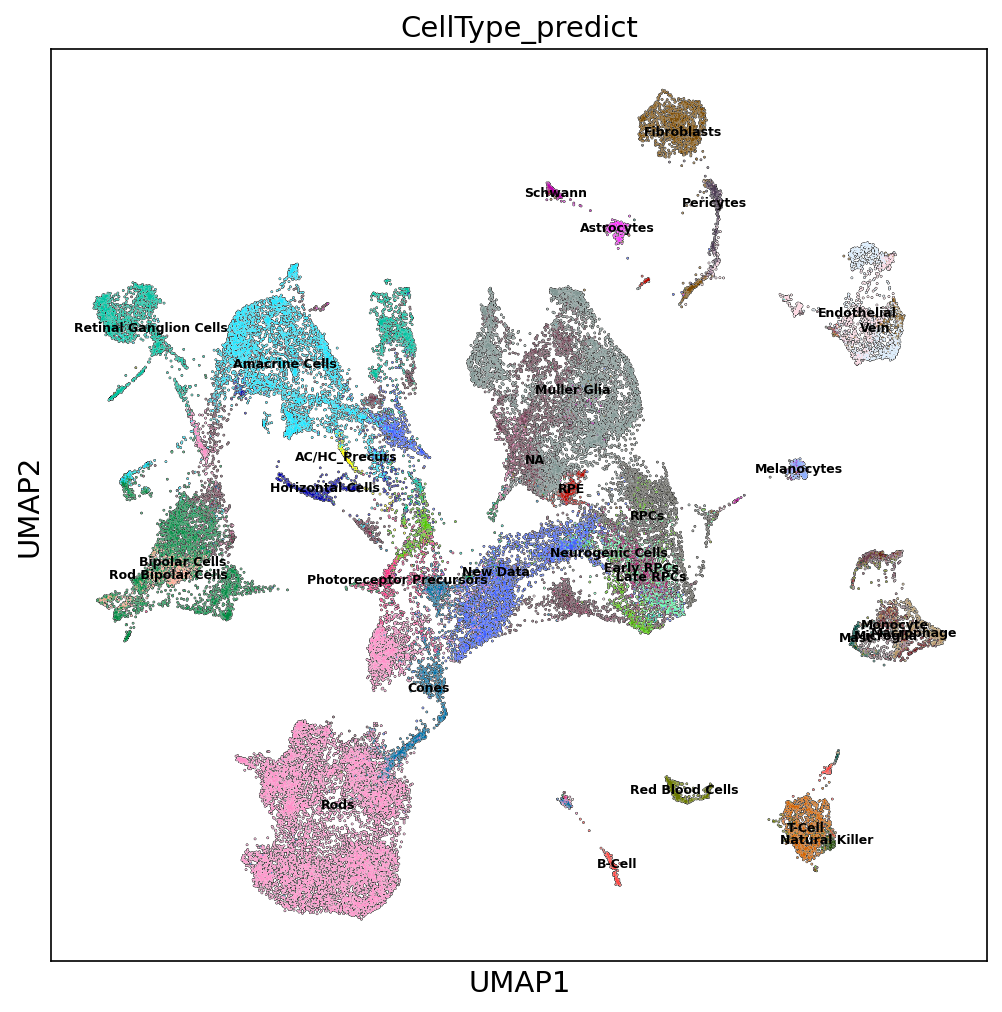

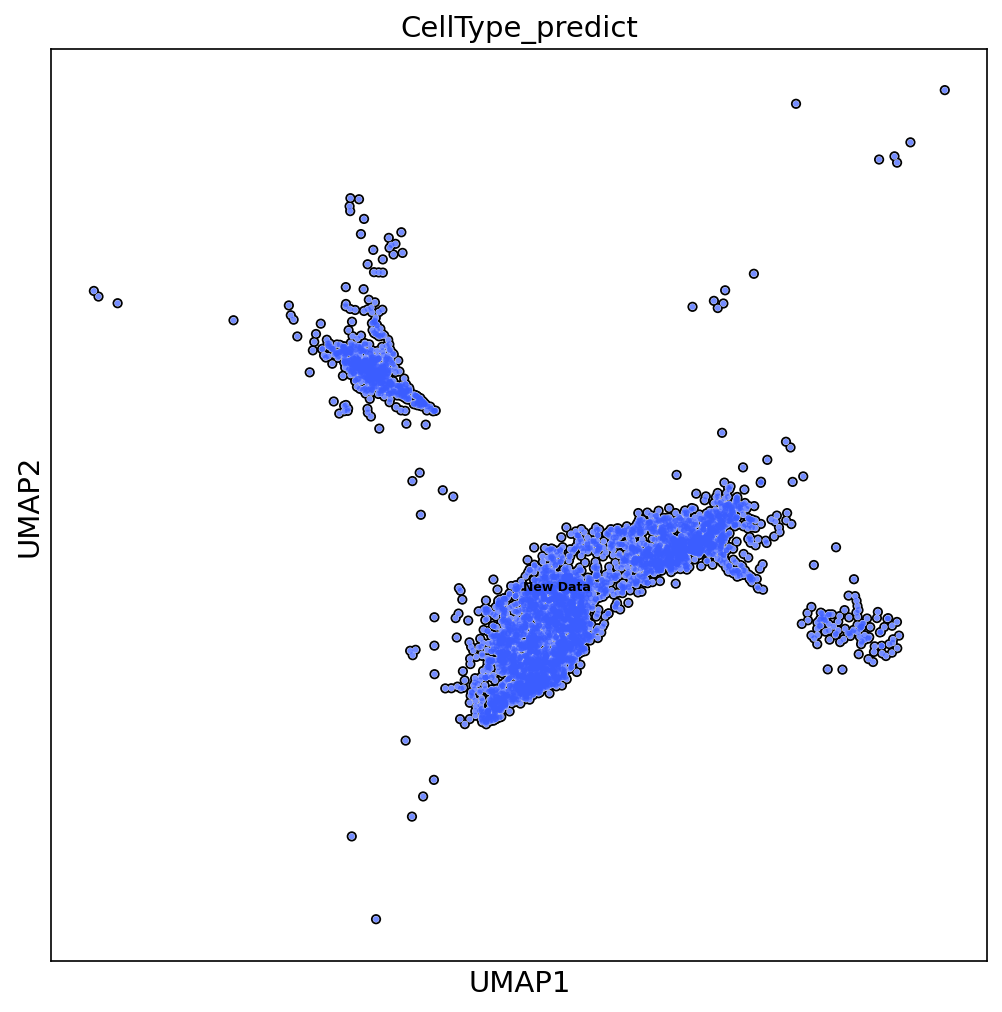

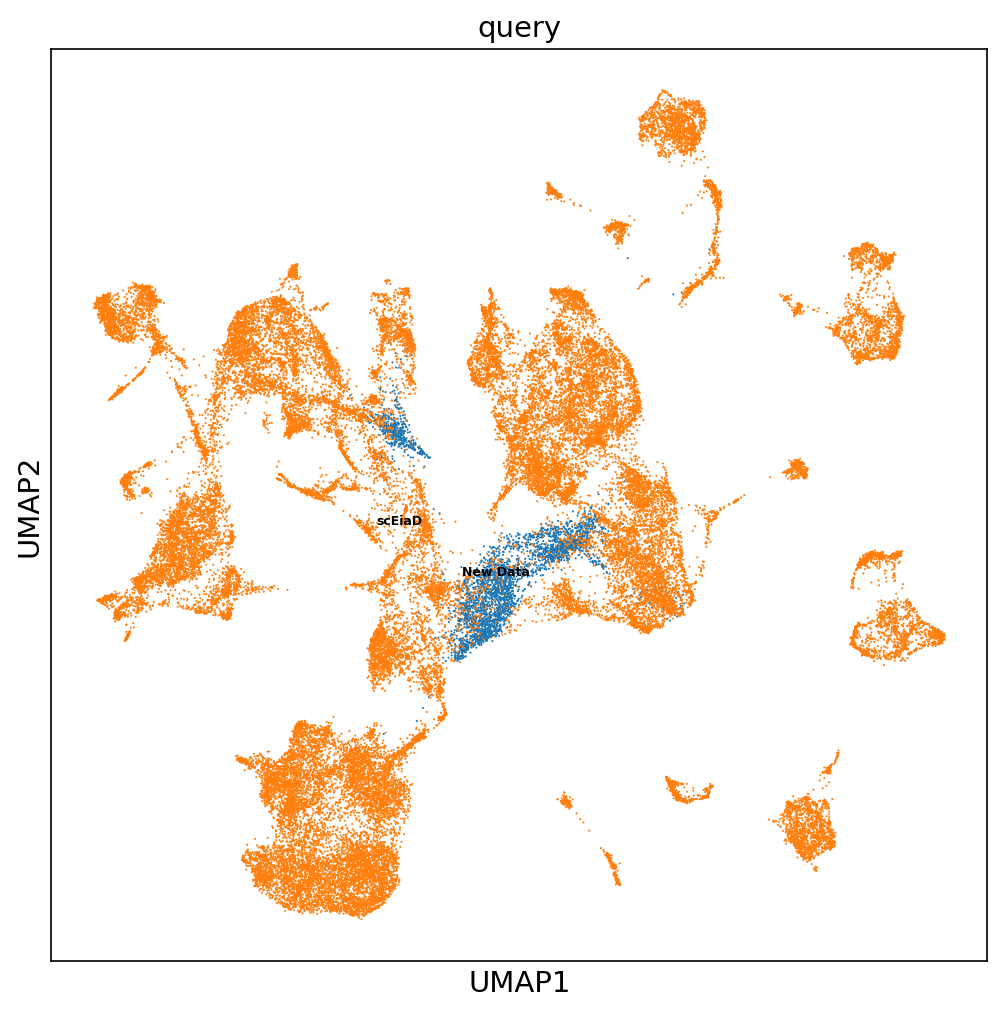

CPU times: user 2.67 s, sys: 36 ms, total: 2.7 s
Wall time: 2.75 s


In [ ]:
%%time
from matplotlib import rcParams
sc.set_figure_params(dpi=150)
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata_full_HVG, color = 'CellType_predict', add_outline=True, legend_loc='on data',  legend_fontsize=6)
sc.pl.umap(adata_full_HVG[adata_full_HVG.obs['query'] != 'scEiaD'], color = 'CellType_predict', add_outline=True, legend_loc='on data',  legend_fontsize=6)
sc.pl.umap(adata_full_HVG, color = 'query',legend_loc='on data', legend_fontsize=6, size = 4)

# Extract scVI latent dims and/or UMAP coords
If you want to use the coords in Seurat, then here is an example how you could extract them to a text file for ingress into, say, Seurat.